# Final Group Assignment
- Analyzing news articles to determine if they are fake or real, using a dataset from kaggle.

### 1. Analysis: Frame the problem and look at the big picture
2. Define the objective in business terms: Create a model capable of recognizing fake and real news.
3. How should you frame the problem (supervised/unsupervised etc.)?: Supervised learning, with binary labeling (1 for real, 0 for fake news) 
4. How should performance be measured?: Performance will be measured by the model accuracy, correctly classified vs. all.

In [4]:
#imports
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
from gensim.models import Word2Vec

### 2. Get the data
Data were retrieved from Kaggle (link below). This data set consists of 2 csv files, one with the real and other with the real news. Both data sets have 'Title', 'Text', 'Subject' and 'Date' columns. 

https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset

In the next step we labeled fake and real data, with 0 and 1 respectively and then merged them into 1 dataframe and shuffled them.

In [5]:
#Load & label fake news data
df_fake = pd.read_csv('Fake.csv')
df_fake['label'] = 0

In [6]:
#Load & label real news data
df_true = pd.read_csv('True.csv')
df_true['label'] = 1
#rename all 'politicsNews' to 'politics' in df_true
df_true['subject'] = df_true['subject'].replace('politicsNews', 'politics')

In [7]:
#print distinct subjects
print(df_fake['subject'].unique())
print(df_true['subject'].unique())

['News' 'politics' 'Government News' 'left-news' 'US_News' 'Middle-east']
['politics' 'worldnews']


In [8]:
#merge & shuffle data
df_news = pd.concat([df_fake, df_true]).sample(frac=1).reset_index(drop=True)
df_news.head()

,title,text,subject,date,label
0,"In message to Russia, Western powers demand U....",PARIS (Reuters) - Major Western powers appeare...,worldnews,"November 8, 2017",1
1,"Trump may have stopped the bleeding, but not t...",WASHINGTON (Reuters) - Donald Trump may have ...,politics,"October 10, 2016",1
2,YOU CAN’T MAKE THIS UP: East Chicago Residents...,He won on a platform of reducing crime or some...,politics,"Nov 7, 2015",0
3,Ukraine president denies hampering anti-corrup...,VILNIUS/KIEV (Reuters) - Ukrainian President P...,worldnews,"December 8, 2017",1
4,U.S. Senator Lee to oppose motion to begin hea...,WASHINGTON (Reuters) - Republican Senator Mike...,politics,"June 27, 2017",1


# 3. Explore and visualise the data to gain insights

# Visualization

In [9]:
#group data by subject and label
df_news.groupby(['subject', 'label']).size()

subject          label
Government News  0         1570
Middle-east      0          778
News             0         9050
US_News          0          783
left-news        0         4459
politics         0         6841
                 1        11272
worldnews        1        10145
dtype: int64

label
0    23481
1    21417
dtype: int64


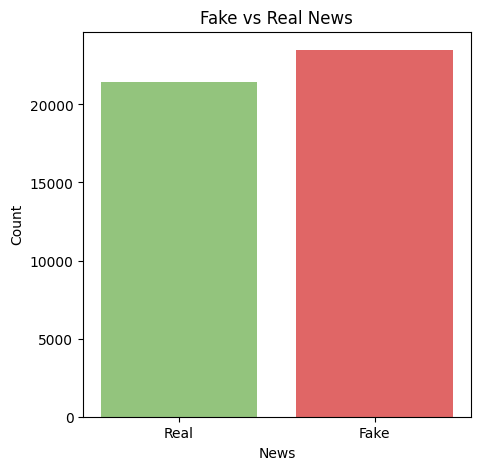

In [10]:
#fake vs real news
print(df_news.groupby(['label']).size())

import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.bar(df_news['label'].unique(), df_news.groupby(['label']).size(), color=['#e06666','#93c47d'])
plt.xticks(df_news['label'].unique(), ['Fake', 'Real'])
plt.xlabel('News')
plt.ylabel('Count')
plt.title('Fake vs Real News')
plt.show()

<Axes: xlabel='subject'>

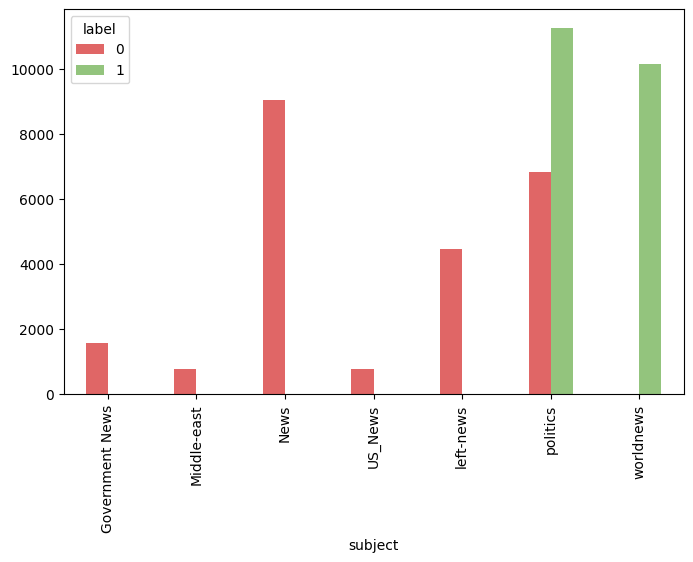

In [11]:
#number of articles per subject and label
df_news.groupby(['subject', 'label']).size().unstack().plot(kind='bar', color=['#e06666','#93c47d'], stacked=False, figsize=(8, 5))

In [12]:
#print the full text of the first 5 articles of subject 'worldnews'
for i in range(5):
    print(df_news[(df_news['subject'] == 'worldnews') & (df_news['label'] == 1)]['text'].iloc[i])
    print('---------------------------------')

PARIS (Reuters) - Major Western powers appeared ready for a showdown with Russia at the U.N. Security Council after demanding on Wednesday the renewal of he mandate of an international inquiry into chemical weapons attacks in Syria.  Russian Deputy Foreign Minister Sergei Ryabkov said on Wednesday Moscow opposed a draft U.N. resolution to extend the mandate of the investigation by the United Nations and the Organization for the Prohibition of Chemical Weapons (OPCW) into chemical weapons attacks in Syria. Ryabkov s comments came hours after Russia rejected a report by the international inquiry blaming the Syrian government for a deadly toxic gas attack on April 4. In a joint statement by the foreign ministers of Britain, France, Germany and the United States, the four countries said they had full confidence in the findings and called on the Syrian regime to end all use of poison gas and finally declare to the OPCW all the chemical weapons it possesses.  We therefore urge the United Nat

label
0    423.197905
1    385.640099
Name: text, dtype: float64


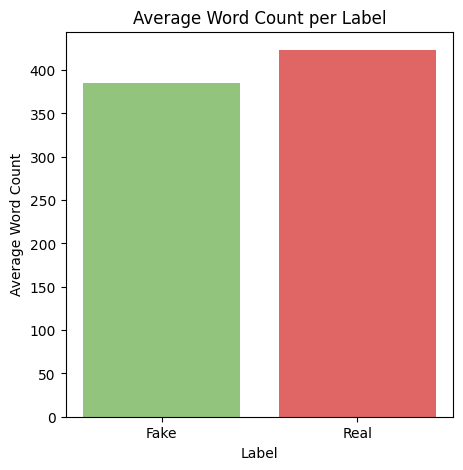

In [13]:
#average word count of articles per label
import matplotlib.pyplot as plt

print(df_news.groupby(['label'])['text'].apply(lambda x: x.str.split().str.len().mean()))
plt.figure(figsize=(5,5))
plt.bar(df_news['label'].unique(), df_news.groupby(['label'])['text'].apply(lambda x: x.str.split().str.len().mean()), color=['#e06666','#93c47d'])
plt.title('Average Word Count per Label')
plt.ylabel('Average Word Count')
plt.xlabel('Label')
plt.xticks(np.arange(2), ('Fake', 'Real'), rotation=0)
plt.show()

<Axes: xlabel='subject'>

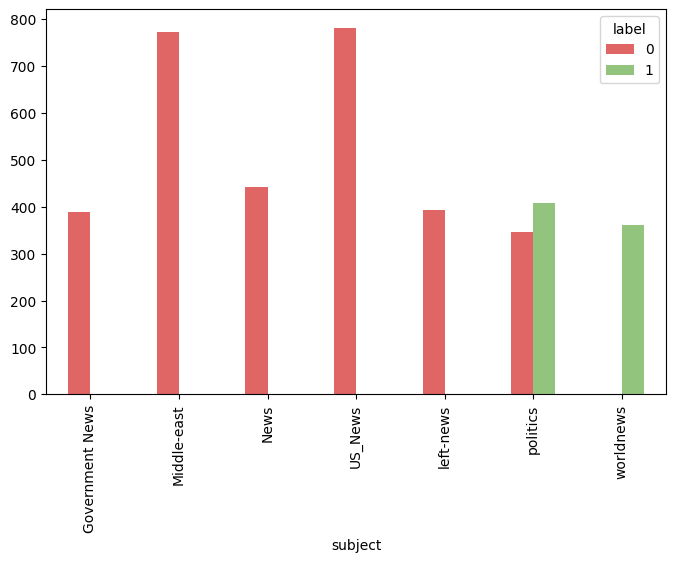

In [14]:
#average word count of articles per subject per label
df_news.groupby(['subject', 'label'])['text'].apply(lambda x: x.str.split().str.len().mean()).unstack().plot(kind='bar', color=['#e06666','#93c47d'], figsize=(8, 5))

# Correlation

<Axes: xlabel='date'>

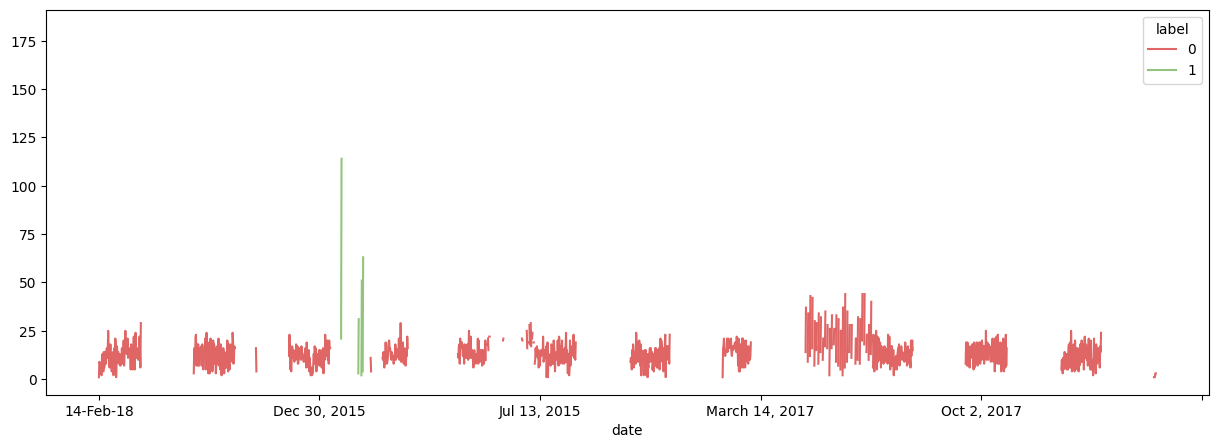

In [15]:
#correlation between date and label
df_news.groupby(['date', 'label']).size().unstack().plot(kind='line', color=['#e06666','#93c47d'], figsize=(15, 5), label=['Fake', 'Real'])

contains_Reuters  label
False             0        23170
                  1           39
True              0          311
                  1        21378
dtype: int64


[Text(0, 0, 'No'), Text(1, 0, 'Yes')]

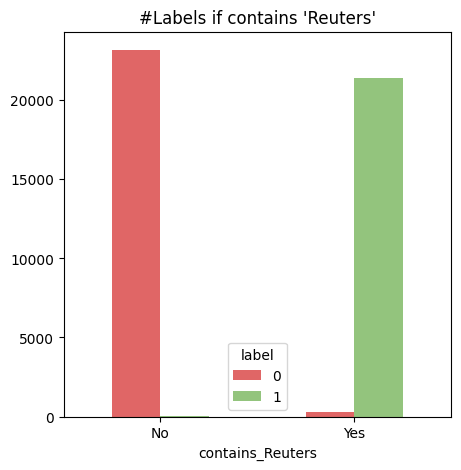

In [16]:
#add column 'contains_Reuters' that will be 1 if the article contains the word 'Reuters' in title or text, 0 otherwise
df_news['contains_Reuters'] = df_news['title'].str.contains('Reuters') | df_news['text'].str.contains('Reuters')

#correlation between label and 'contains_Reuters'
print(df_news.groupby(['contains_Reuters', 'label']).size())
df_news.groupby(['contains_Reuters', 'label']).size().unstack().plot(
    kind='bar',
    color=['#e06666','#93c47d'],
    title="#Labels if contains 'Reuters'",
    figsize=(5, 5),
    ).set_xticklabels(['No', 'Yes'], rotation=0)

- The plot above shows the correlation between the authenticity of the news and whether the news agency Reuters appears as a source or not, which we noticed while taking a first glance at the data.
- This is self-explanatory, since Reuters is a reliable source of information.
- There are a few outliers where the news are fake even if 'Reuters' appears in the text or is cited as the source, but the text overall probably contains half true information.

In [17]:
#remove REUTERS, Reuters, reuters from text
df_news['text'] = df_news['text'].apply(lambda x: x.replace('REUTERS', ''))
df_news['text'] = df_news['text'].apply(lambda x: x.replace('Reuters', ''))
df_news['text'] = df_news['text'].apply(lambda x: x.replace('reuters', ''))

#remove REUTERS, Reuters, reuters from title
df_news['title'] = df_news['title'].apply(lambda x: x.replace('REUTERS', ''))
df_news['title'] = df_news['title'].apply(lambda x: x.replace('Reuters', ''))
df_news['title'] = df_news['title'].apply(lambda x: x.replace('reuters', ''))

# 4. Prepare the data

- function for transforming text data: TF-IDF (Term Frequency - Inverse Document Frequency) 
- splitting the data including training, testing and validation sets
- using only title and text on the X variable
- labels will be the label column (0 or 1, namely fake or real)

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

def transform_with_tfidf(X_train, X_val, X_test, max_df=0.6, max_features=None):
    """
    Transform input data using TfidfVectorizer.

    Parameters:
    - X_train: Training data
    - X_val: Validation data
    - X_test: Test data
    - max_df: Maximum document frequency for TfidfVectorizer

    Returns:
    - X_train_tfidf: Transformed training data
    - X_val_tfidf: Transformed validation data
    - X_test_tfidf: Transformed test data
    """

    if max_features:
        tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=max_df, max_features=max_features)
    else:
        tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=max_df)

    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

    X_val_tfidf = tfidf_vectorizer.transform(X_val)
    X_test_tfidf = tfidf_vectorizer.transform(X_test)

    return X_train_tfidf, X_val_tfidf, X_test_tfidf

In [19]:
X = df_news['title'] + ' ' + df_news['text']
y = df_news['label']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [20]:
X_train.head()

36335    U.S. extends some Iran sanctions relief under ...
12384    Health secretary says healthcare bill is 'work...
24419    Pakistan finance minister denies corruption ch...
24740    BENGHAZI PANEL CALLS HILLARY TO TESTIFY UNDER ...
27039     #NeverTrump GOP Delegates: Party Brass Intimi...
dtype: object

# 5. Short-list promising models
- we are sorting them by the method we are using to transform the text:
   - for TF-IDF: MultinomialNaiveBayes, K-Nearest-Neighbors as classifiers, CNN and RNN as neural networks
   - for Word2Vec: A simple neural network with default parameters

## I. TF-IDF

In [21]:
X_train_tfidf, X_val_tfidf, X_test_tfidf = transform_with_tfidf(X_train, X_val, X_test, max_df=0.6)

                           term         rank
101747                    trump  1962.723373
79147                 president   743.535517
23919                   clinton   632.636287
72079                     obama   602.082817
48349                     house   557.481370
...                         ...          ...
73614                    osdlac     0.001529
104822                useragent     0.001529
73615                  osdlamrc     0.001529
43379   goog_dom_content_loaded     0.001529
58000                    lac_ex     0.001529

[111977 rows x 2 columns]


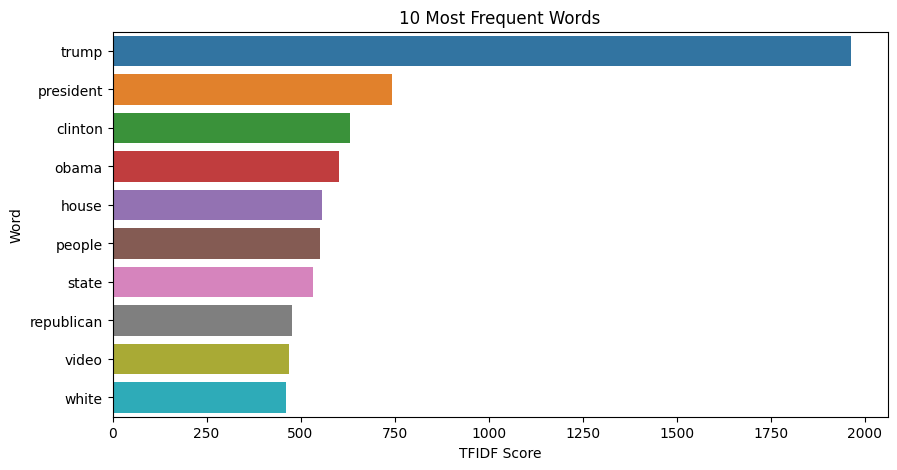

In [39]:
# visualize 10 most frequent words and their tfidf score
import matplotlib.pyplot as plt
import seaborn as sns

tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.6)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Get feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

# Sum tfidf frequency of each term through documents
sums = X_train_tfidf.sum(axis=0)

# Connecting term and sum frequency
data = []
for col, term in enumerate(feature_names):
    data.append( (term, sums[0,col] ))

ranking = pd.DataFrame(data, columns=['term','rank'])
print(ranking.sort_values('rank', ascending=False))

plt.figure(figsize=(10, 5))
sns.barplot(x='rank', y='term', data=ranking.sort_values('rank', ascending=False).head(10))
plt.title('10 Most Frequent Words')
plt.xlabel('TFIDF Score')
plt.ylabel('Word')
plt.show()

### a) Multinomial naive bayes 

In [ ]:
clf = MultinomialNB()
clf.fit(X_train_tfidf, y_train)

y_pred = clf.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

y_val_pred = clf.predict(X_val_tfidf)

val_accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {val_accuracy:.2f}')

print(classification_report(y_test, y_pred))

### b) KNN with an arbitrary number of neighbors

In [ ]:
knn_classifier = KNeighborsClassifier(n_neighbors=5) 
knn_classifier.fit(X_train_tfidf, y_train)

y_pred = knn_classifier.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy:.2f}')

print(classification_report(y_test, y_pred))

### c) Convolutional Neural Network

In [ ]:
#CNN
from tensorflow import keras

X_train_tfidf, X_val_tfidf, X_test_tfidf = transform_with_tfidf(X_train, X_val, X_test, max_df=0.6, max_features=5000)

cnn_model = keras.Sequential([
    keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(X_train_tfidf.shape[1], 1)),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

cnn_model.summary()

In [ ]:
#print type of X_train_tfidf
print(type(X_train_tfidf))

#count number of vectors in first row of X_train_tfidf
print(len(X_train_tfidf[0].data))
print(len(X_train_tfidf[1].data))
print(len(X_train_tfidf[2].data))
print(len(X_train_tfidf[-2].data))

In [ ]:
print(X_train_tfidf[-2].shape)
print(X_train_tfidf[-2].data)

In [ ]:
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

X_train_tfidf_arr = X_train_tfidf.toarray()
X_val_tfidf_arr = X_val_tfidf.toarray()

history = cnn_model.fit(X_train_tfidf_arr, y_train, epochs=10, batch_size=128, validation_data=(X_val_tfidf_arr, y_val), callbacks=[es])

#plot training and validation accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#evaluate model on test data
X_test_tfidf_arr = X_test_tfidf.toarray()

test_loss, test_acc = cnn_model.evaluate(X_test_tfidf_arr, y_test, verbose=2)
print(f'Test accuracy: {test_acc:.2f}')

### d) Logisitic regression

In [ ]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression

X_train_tfidf, X_val_tfidf, X_test_tfidf = transform_with_tfidf(X_train, X_val, X_test, max_df=0.6, max_features=10000)

# lr = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, random_state=42, C=0.5, max_iter=1000)
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)

y_pred = lr.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

In [ ]:
#plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

In [ ]:
#print one of the misclassified articles
print(X_test[y_test != y_pred].iloc[1])

### d) Recursive Neural Network

In [ ]:
#LSTM RNN

X_train_tfidf, X_val_tfidf, X_test_tfidf = transform_with_tfidf(X_train, X_val, X_test, max_df=0.6, max_features=5000)

lstm_model = keras.Sequential([
    keras.layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2, input_shape=(X_train_tfidf.shape[1], 1)),
    keras.layers.Dense(1, activation='sigmoid')
])

lstm_model.summary()

In [ ]:
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

X_train_tfidf_arr = X_train_tfidf.toarray()
X_val_tfidf_arr = X_val_tfidf.toarray()

history = lstm_model.fit(X_train_tfidf_arr, y_train, epochs=10, batch_size=128, validation_data=(X_val_tfidf_arr, y_val), callbacks=[es])

#plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('LSTM Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#evaluate model on test data
X_test_tfidf_arr = X_test_tfidf.toarray()

test_loss, test_acc = lstm_model.evaluate(X_test_tfidf_arr, y_test, verbose=2)
print(f'Test accuracy: {test_acc:.2f}')

### f) Testing out the most promising one from above with new data (some random article texts)

## II) Using WordEmbeddings for text representation (Word2Vec) and a simple neural network

In [ ]:
X = df_news['title'] + ' ' + df_news['text']
y = df_news['label']

# Convert labels to numerical values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenize the text data
max_words = 10000  # Adjust based on the size of your vocabulary
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure consistent length for input to neural network
max_sequence_length = 1000  # Adjust based on your dataset
X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_sequence_length)

# Train Word2Vec model
tokenized_sentences = [text.split() for text in X_train]
word2vec_model = Word2Vec(sentences=tokenized_sentences, vector_size=100, window=5, min_count=1, workers=4)

# Create an embedding matrix
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < max_words:
        try:
            embedding_vector = word2vec_model.wv[word]
            embedding_matrix[i] = embedding_vector
        except KeyError:
            # Word not in Word2Vec model vocabulary
            pass

# Build a simple neural network model
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_sequence_length, weights=[embedding_matrix], trainable=False))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_padded, y_train, epochs=5, batch_size=32, validation_split=0.2)

In [ ]:
# Evaluate the model on the test set
y_pred = model.predict(X_test_padded)
y_pred = y_pred.flatten()

# Convert predictions back to original labels
y_pred_labels = label_encoder.inverse_transform(((y_pred > 0.5).astype(int)))
print(y_pred_labels)
print(y_test)
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_labels)
print(f'Test Accuracy: {accuracy:.2f}')

# Print classification report for the test set
print(classification_report(y_test, y_pred_labels))

# 6. Choosing a model and fine-tuning it

## 7. Video link